AI statement:
"I certify that the code and data in this assignment were generated independently, using only the tools
and resources defined in the course and that I did not receive any external help, coaching, or contributions
during the production of this work."

Dependencies

In [1]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install -y xvfb x11-utils
!pip install hiddenlayer
!pip install PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!pip install gym[atari]
!python -m pip install pyvirtualdisplay
!pip install box2d
!pip install pygame
!pip install tqdm
!pip install lz4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
from pyvirtualdisplay import Display
import gym
from IPython import display as ipythondisplay
import random

import cv2

import hiddenlayer as hl
import numpy as np
import torch
from torchsummary import summary
from google.colab import files

from gym import spaces
import pandas as pd
import math
import io
from base64 import b64decode, b64encode
from IPython.core.display import display, HTML
from gym.wrappers.frame_stack import FrameStack
from gym.wrappers.gray_scale_observation import GrayScaleObservation
from gym.wrappers.resize_observation import ResizeObservation
from gym.wrappers.transform_observation import TransformObservation
from gym.wrappers.transform_reward import TransformReward

import collections
import copy

import random

from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7.5)

In [3]:
#For display

display = Display(visible=False, size=(400, 300))
display.start() 

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Part I: Exploring Gym Environments



#### Cartpole-v1

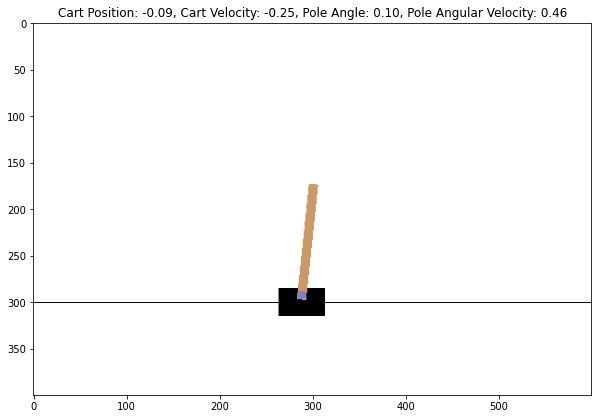

In [4]:
# Load the gym environment
env = gym.make('CartPole-v1')

# Let's watch how an untrained agent moves around
state = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.title(f"Cart Position: {state[0]:.2f}, Cart Velocity: {state[1]:.2f}, Pole Angle: {state[2]:.2f}, Pole Angular Velocity: {state[3]:.2f}")
plt.imshow(prev_screen)
for j in range(10):
    action = random.choice(range(2))
    screen = env.render(mode='rgb_array')
    plt.title(f"Cart Position: {state[0]:.2f}, Cart Velocity: {state[1]:.2f}, Pole Angle: {state[2]:.2f}, Pole Angular Velocity: {state[3]:.2f}")
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

ipythondisplay.clear_output(wait=True)        
env.close()

Read Environment Properties

In [5]:
''' Action Space
    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction of the fixed force the cart is pushed with.
    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |
'''
print(env.action_space)

Discrete(2)


In [6]:
    ''' Observation Space
        The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:
        | Num | Observation           | Min                  | Max                |
        |-----|-----------------------|----------------------|--------------------|
        | 0   | Cart Position         | -4.8                 | 4.8                |
        | 1   | Cart Velocity         | -Inf                 | Inf                |
        | 2   | Pole Angle            | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°)  |
        | 3   | Pole Angular Velocity | -Inf                 | Inf                |
    '''
    print(env.observation_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


**Rewards**  
    Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.<br><br>
**Starting State**  
    All observations are assigned a uniformly random value in `(-0.05, 0.05)`<br><br>
**Episode Termination**  
    The episode terminates if any one of the following occurs:<br>
1.   Pole Angle is greater than ±12°
2.   Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3.   Episode length is greater than 500 (200 for v0)


#### MountainCar-v0

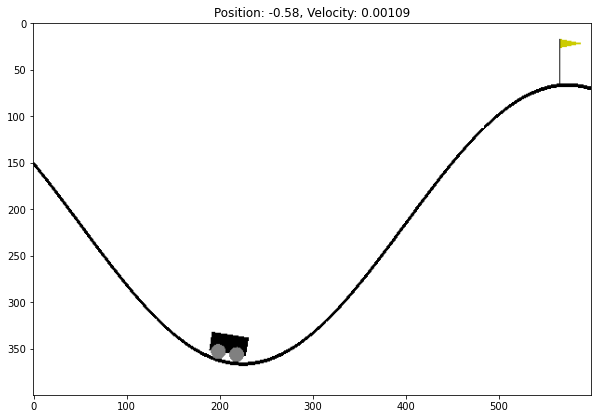

In [7]:
env2 = gym.make('MountainCar-v0')
env2.seed(23)
env2.reset()

# Let's watch how an untrained agent moves around

state = env2.reset()
prev_screen = env2.render(mode='rgb_array')
plt.title(f"Position: {state[0]:.2f}, Velocity: {state[1]:.5f}")
plt.imshow(prev_screen)
for j in range(10):
#     action = agent.act(state)
    action = random.choice(range(3))
    screen = env2.render(mode='rgb_array')
    plt.title(f"Position: {state[0]:.2f}, Velocity: {state[1]:.5f}")
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = env2.step(action)
    if done:
        break 
        
env2.close()

In [8]:
''' Action Space
    There are 3 discrete deterministic actions:
    | Num | Observation                                                 | Value   | Unit |
    |-----|-------------------------------------------------------------|---------|------|
    | 0   | Accelerate to the left                                      | Inf    | position (m) |
    | 1   | Don't accelerate                                            | Inf  | position (m) |
    | 2   | Accelerate to the right                                     | Inf    | position (m) |
'''
print(env2.action_space)

Discrete(3)


In [9]:
    ''' Observation Space
        The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
        | Num | Observation                                                 | Min                | Max    | Unit |
        |-----|-------------------------------------------------------------|--------------------|--------|------|
        | 0   | position of the car along the x-axis                        | -Inf               | Inf    | position (m) |
        | 1   | velocity of the car                                         | -Inf               | Inf  | position (m) |
    '''
    print(env2.observation_space)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


**Reward**  
    The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep it isn't at the goal and is not penalised (reward = 0) for when it reaches the goal.<br><br>
**Starting State**  
    The position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.<br><br>
**Episode Termination**  
The episode terminates if either of the following happens:
1. The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
2. The length of the episode is 200.

### Part II: Implementing DQN & Solving grid-world environment

In [10]:
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, observation_space, action_space, max_timesteps, stochasticity=1):
    self.observation_space = spaces.Discrete(observation_space)
    self.action_space = spaces.Discrete(action_space)
    self.max_timesteps = max_timesteps
    self.stochasticity = stochasticity

  def set_epsilon(self, epsilon):
    self.epsilon = epsilon

  def reset(self):
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.state = np.zeros((4, 4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    return observation

  def step(self, action):

    if self.stochasticity != 1:
      action = self.get_action_random(action)

    current_pos = copy.deepcopy(self.agent_pos)

    if action == 0: # Go left
      self.agent_pos[0] -= 1
    if action == 1: # Go up
      self.agent_pos[1] -= 1
    if action == 2: # Go right
      self.agent_pos[0] += 1
    if action == 3: # Go down
      self.agent_pos[1] += 1
    
    self.agent_pos = list(np.clip(self.agent_pos, 0, 3))
    future_pos = self.agent_pos
    self.state = np.zeros((4,4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()

    reward = self.get_reward(current_pos, future_pos)

    self.timestep += 1
    done = True if self.timestep >= self.max_timesteps or self.agent_pos == self.goal_pos else False
    info = {}

    return observation, reward, done, info, action

  # the reward is calculated on the basis of the distance of the
  # current_pos and future_pos of the agent from the goal_pos
  def get_reward(self, current_pos, future_pos):

    current_dist = self.distance_from_goal(current_pos)
    final_dist = self.distance_from_goal(future_pos)

    if final_dist < current_dist:
      return 1
    else:
      return -1
  
  def distance_from_goal(self, pos):
    x_final, y_final = self.goal_pos
    x, y = pos
    return math.sqrt( (y_final - y)**2 + (x_final - x)**2 )

  def get_action_random(self, action):
    if action == 1:
      return 3
    else:
      return action
      

  # https://stackoverflow.com/questions/25698448/how-to-embed-html-into-ipython-output
  # https://stackoverflow.com/questions/55562088/open-base64-string-image-in-jupyter-notebook-without-saving
  # https://stackoverflow.com/questions/49015957/how-to-get-python-graph-output-into-html-webpage-directly
  # https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/
  def render(self):
    plt.figure()
    # plt.imshow(self.state)
    img = io.BytesIO()
    plt.imsave(img, self.state)
    img.seek(0)
    img_val = img.getvalue()
    # print(img_val)
    encoded_image = b64encode(img_val)
    my_html = '<img height="225px" width="300px" src="data:image/png;base64, {}">'.format(encoded_image.decode('utf-8'))
    display.display_html(HTML('<h1>' + my_html + '</h1>'))

The following function returns the action the agent 🤖 will take

In [11]:
stochasticity = 1.0
max_timesteps = 15
observation_space = 16
action_space = 4
max_timesteps = 10

env = GridEnvironment(observation_space, action_space, max_timesteps, stochasticity=1)
obs = env.reset()
env.render()

<Figure size 720x540 with 0 Axes>

In [12]:
def get_action():
    return np.random.choice(env.action_space.n)

def one_hot(x, depth=16):
  return np.take(np.eye(depth), x, axis=0).astype(np.float32)

def get_state_from_position(pos):
    X, Y = env.state.shape
    pos_x, pos_y = pos
    return Y * pos_x + pos_y

In [13]:
# l1 = 16 as it will receive the one hot encoded observation space
l1 = 16
l2 = 32
l3 = 32
l4 = 4
# l4 = 4 becausse of size of action_space
model = torch.nn.Sequential(
  torch.nn.Linear(l1, l2),
  torch.nn.ReLU(),
  torch.nn.Linear(l2, l3),
  torch.nn.ReLU(),
  torch.nn.Linear(l3,l4)
)
if torch.cuda.is_available():
  model = model.cuda()

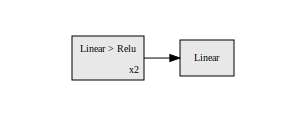

In [14]:
hl.build_graph(model, torch.zeros([1, 16]).cuda())

#### Utility function to train on grid world

In [15]:
def trainGridWorld(model, env, learning_rate = 1e-3,
                  nn_epochs = 1,
                  gamma = 0.9,
                  batch_length = 5,
                  epsilon = 1.0,
                  min_epsilon = 0.001,
                  epochs = 1000,
                  msize = 1000,
                  bsize = 200,                                                                  
                  max_moves = 50,
                  C = 1,
                  seed = 0):
  
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  #Initializing loss function and optimizer

  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  #Setting experience replay parameters

  mem_size = msize * batch_length                                                           
  batch_size = bsize * batch_length

  #Observation list initialization
  
  replay = np.array(list(), dtype=np.int32)
  rate_of_decay = (min_epsilon/epsilon)**(1/epochs)
  losses = list()
  running_reward_list = list()
  epsilon_list = list()
  epsilon_list.append(epsilon)
  tot_reward_list = list()

  debug = True

  t = trange(epochs)

  #Training Loop

  for i in t:
    env.reset()

    completed = False

    loss_ep = list()

    tot_reward = 0

    steps = 0

    model_ = copy.deepcopy(model)

    while not completed:

      current_state = get_state_from_position(env.agent_pos)
      current_state_oh = one_hot(current_state)
      current_state_oh = torch.from_numpy(current_state_oh)
      if torch.cuda.is_available():
          current_state_oh = current_state_oh.cuda()
      qval = model(current_state_oh)                                                   
      qval_ = qval.data.cpu().numpy()

      if (random.random() < epsilon):                                       
        current_action = get_action()
      else:
        current_action = np.argmax(qval_)

      future_state = get_state_from_position(env.agent_pos)
      observation, reward, done, info, action = env.step(current_action)

      tot_reward+=reward
      
      record = np.array([current_state, current_action, reward, future_state, done])
      
      if replay.shape[0] < mem_size: 
        replay = np.append(replay, record, axis=0)
      if replay.shape[0] >= mem_size:
        # print(f"shape: {replay.shape[0]}, episode: {i}")
        replay = replay[5:mem_size]
        # print(f"New shape: {replay.shape[0]}, episode: {i}")
    

      if len(replay) >= batch_size:
        rng = np.random.default_rng()
        minibatch = np.reshape(replay, (len(replay)// batch_length, batch_length))
        minibatch = rng.choice(minibatch, batch_size)
        
        action_ = list()
        reward_ = list()
        done_ = list()
        state1_ = list()
        state2_ = list()

        for val in minibatch:
          
          state1_.append(one_hot(val[0]))

          action_.append(val[1])
          
          reward_.append(val[2])
          
          state2_.append(one_hot(val[3]))
          
          done_.append(val[4])
          
        
        action_ = np.array(action_)
        reward_ = np.array(reward_)
        done_ = np.array(done_)
        state1_ = np.array(state1_)
        state2_ = np.array(state2_)

        state1_batch = torch.from_numpy(state1_).cuda()
        action_batch = torch.from_numpy(action_).cuda()
        reward_batch = torch.from_numpy(reward_).cuda()
        state2_batch = torch.from_numpy(state2_).cuda()
        done_batch = torch.from_numpy(done_).cuda()
        
        for _ in range(nn_epochs):
          Q1 = model(state1_batch)                                           
          with torch.no_grad():
              Q2 = model_(state2_batch)                                      
          
          Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])
          X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
          loss = loss_fn(X, Y.detach())
          optimizer.zero_grad()
          loss.backward()
          loss_ep.append(loss.item())
          optimizer.step() 
      steps+=1
      if(steps%C==0):
          model_ = copy.deepcopy(model) 
      completed = True if done else False
    epsilon = epsilon*rate_of_decay
    epsilon_list.append(epsilon)
    tot_reward_list.append(tot_reward)
    if(len(tot_reward_list)>=10):
      running_reward = np.mean(tot_reward_list[-10:])
      running_reward_list.append(running_reward)
    else:
      running_reward = tot_reward
    if(len(loss_ep)==0):
      losses.append(float('inf'))
    else:
      losses.append(np.average(loss_ep))
    t.set_postfix(loss=np.average(loss_ep), reward = tot_reward, running_reward = running_reward)
    if(running_reward>=5.7):
      print(f"Solved Grid environment at {i+1} epoch. Average running reward: {running_reward:.2f}")
      break

  losses = np.array(losses)

  env.close()

  return {
      'model': model,
      'loss_per_episode' : losses,
      'reward_per_episode' : tot_reward_list,
      'epsilon_per_episode' : epsilon_list,
      'running_reward_list' : running_reward_list
  }

In [16]:
gridWorldRes = trainGridWorld(model, env)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Solved Grid environment at 155 epoch. Average running reward: 5.70


In [17]:
torch.save(model.state_dict(), 'gridVDQN.pth')

# download checkpoint file
files.download('gridVDQN.pth')

state_dict = torch.load('gridVDQN.pth')
# print(state_dict.keys())
model.load_state_dict(state_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<All keys matched successfully>

In [18]:
losses = gridWorldRes['loss_per_episode']
tot_reward_list = gridWorldRes['reward_per_episode']
epsilon_list = gridWorldRes['epsilon_per_episode']
running_reward_list = gridWorldRes['running_reward_list']

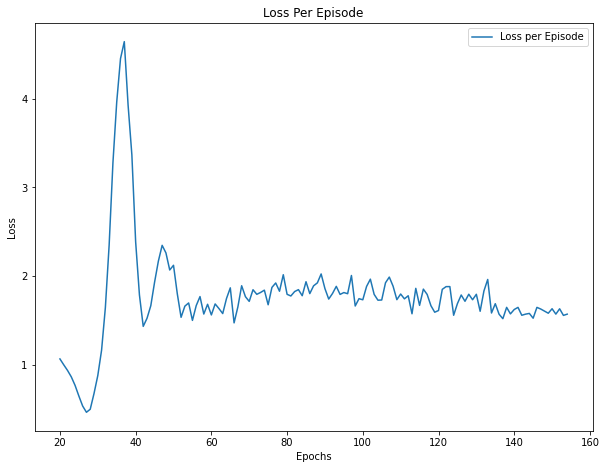

In [19]:
plt.title("Loss Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, label = 'Loss per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

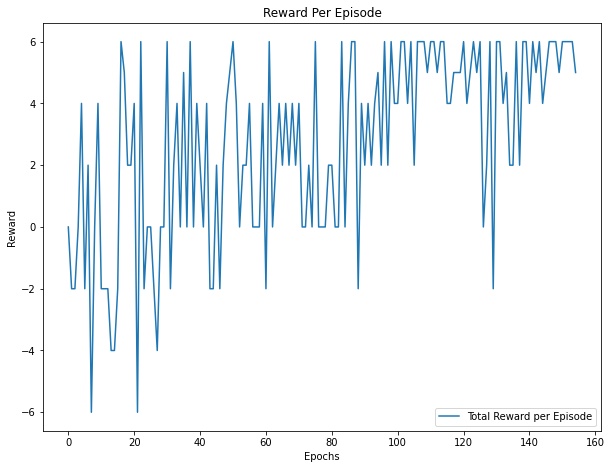

In [20]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(tot_reward_list)), tot_reward_list, label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

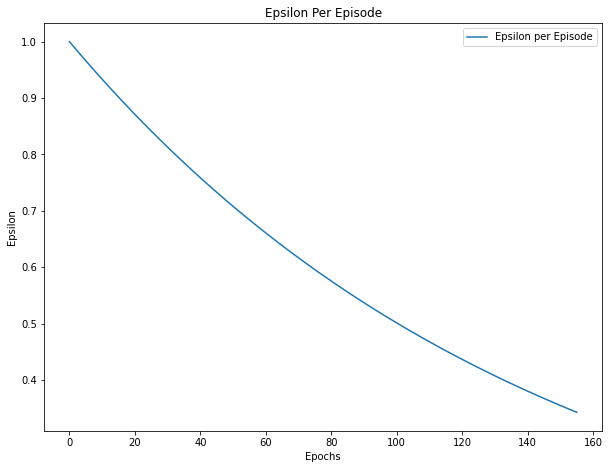

In [21]:
plt.title("Epsilon Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.plot(range(len(epsilon_list)), epsilon_list, label = 'Epsilon per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

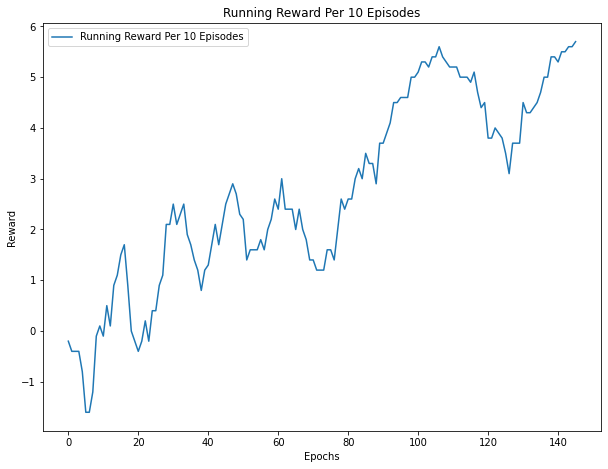

In [22]:
plt.title("Running Reward Per 10 Episodes")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(running_reward_list)), running_reward_list, label = 'Running Reward Per 10 Episodes')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

In [23]:
def evaluateGridAgent(model, env):
  rewards_list = list()

  for i in range(10):  
    env.reset()

    completed = False

    reward_list = list()

    tot_reward = 0

    steps = 0

    loss_ep = list()

    while not completed:

      current_state = get_state_from_position(env.agent_pos)
      current_state_oh = one_hot(current_state)
      current_state_oh = torch.from_numpy(current_state_oh).cuda()
      with torch.no_grad():
        qval = model(current_state_oh)                                                   
      
      qval_ = qval.data.cpu().numpy()
      
      current_action = np.argmax(qval_)

      observation, reward, done, info, action = env.step(current_action)

      tot_reward += reward

      reward_list.append(tot_reward)

      steps += 1

      completed = True if done else False

    rewards_list.append(reward_list)

  env.close()

  return rewards_list

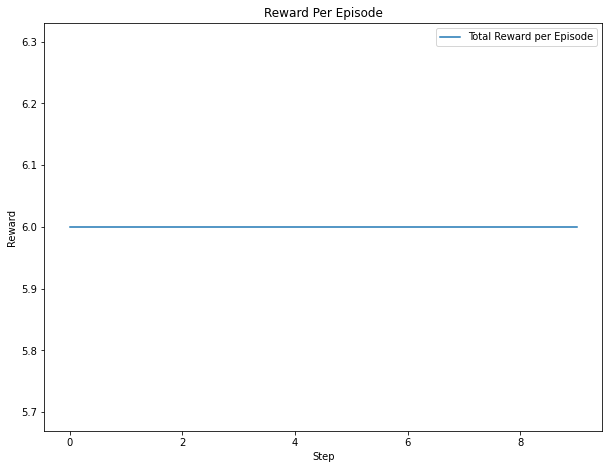

In [24]:
rewards_list = evaluateGridAgent(model, env)
rewards = np.array(rewards_list)

plt.title("Reward Per Episode")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.plot(range(10), rewards[:, 5], label = 'Total Reward per Episode')
plt.legend()

# Part III - DQN and Duel DQN on OpenAI Gym environments





## I. Dueling DQN on Gridworld

In [25]:
class GridDuelDQN(torch.nn.Module):
  def __init__(self, input_dims, output_dims):
    super(GridDuelDQN, self).__init__()
    self.input_dims = input_dims
    self.output_dims = output_dims

    self.features_network = torch.nn.Sequential(
      torch.nn.Linear(self.input_dims, 32),
      torch.nn.ReLU(),
      torch.nn.Linear(32, 32),
      torch.nn.ReLU()
    )
    self.value_network = torch.nn.Sequential(
      torch.nn.Linear(32, 32),
      torch.nn.ReLU(),
      torch.nn.Linear(32,1)
    )
    self.advantage_network = torch.nn.Sequential(
      torch.nn.Linear(32, 32),
      torch.nn.ReLU(),
      torch.nn.Linear(32,self.output_dims)
    )
  
  def forward(self, state):
    features = self.features_network(state)
    value = self.value_network(features)
    adv = self.advantage_network(features)
    q_val = value+(adv - adv.mean())
    return q_val

In [26]:
duelModel = GridDuelDQN(16,4)
if torch.cuda.is_available():
  duelModel = duelModel.cuda()

In [27]:
gridDuelResults = trainGridWorld(duelModel, env, nn_epochs=4, C=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Solved Grid environment at 153 epoch. Average running reward: 5.80


In [28]:
torch.save(duelModel.state_dict(), 'gridDDQN.pth')

# download checkpoint file
files.download('gridDDQN.pth')

state_dict = torch.load('gridDDQN.pth')
# print(state_dict.keys())
duelModel.load_state_dict(state_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<All keys matched successfully>

In [29]:
losses = gridDuelResults['loss_per_episode']
tot_reward_list = gridDuelResults['reward_per_episode']
epsilon_list = gridDuelResults['epsilon_per_episode']
running_reward_list = gridDuelResults['running_reward_list']

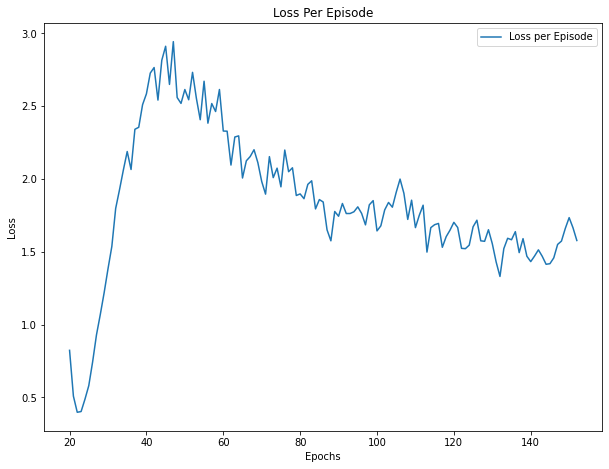

In [30]:
plt.title("Loss Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, label = 'Loss per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

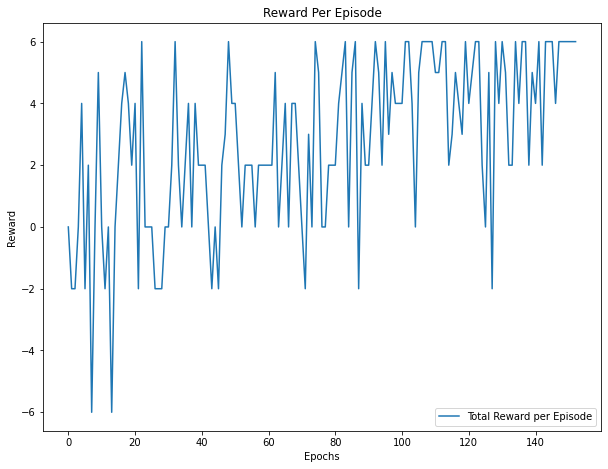

In [31]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(tot_reward_list)), tot_reward_list, label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

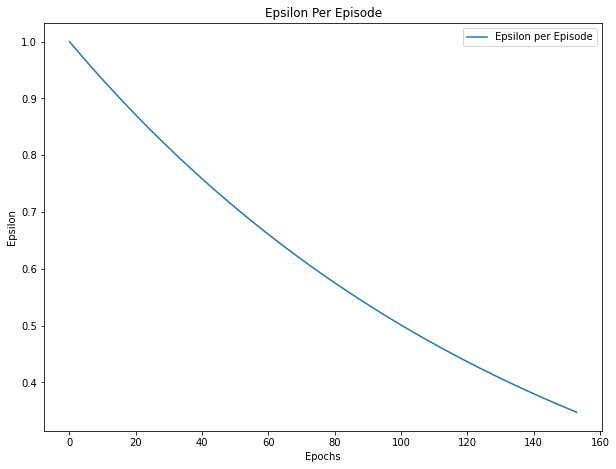

In [32]:
plt.title("Epsilon Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.plot(range(len(epsilon_list)), epsilon_list, label = 'Epsilon per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

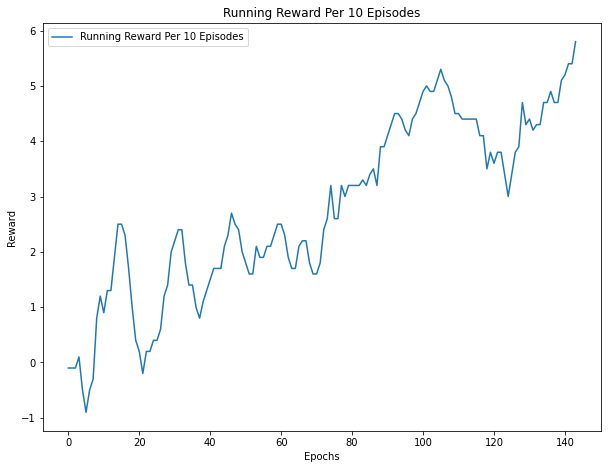

In [33]:
plt.title("Running Reward Per 10 Episodes")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(running_reward_list)), running_reward_list, label = 'Running Reward Per 10 Episodes')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

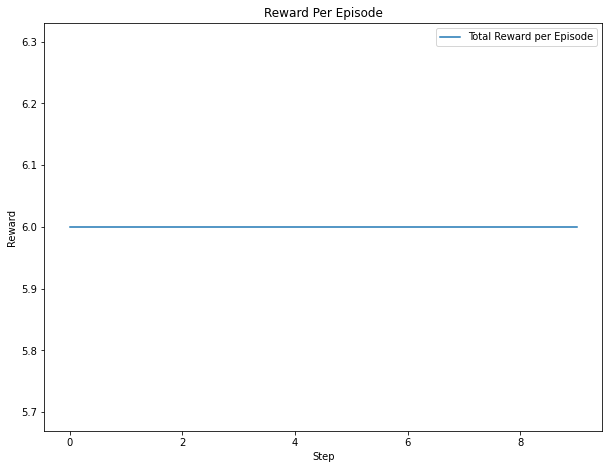

In [34]:
rewards_list = evaluateGridAgent(duelModel, env)
rewards = np.array(rewards_list)

plt.title("Reward Per Episode")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.plot(range(10), rewards[:, 5], label = 'Total Reward per Episode')
plt.legend()

### Comparsion with Vanilla DQN

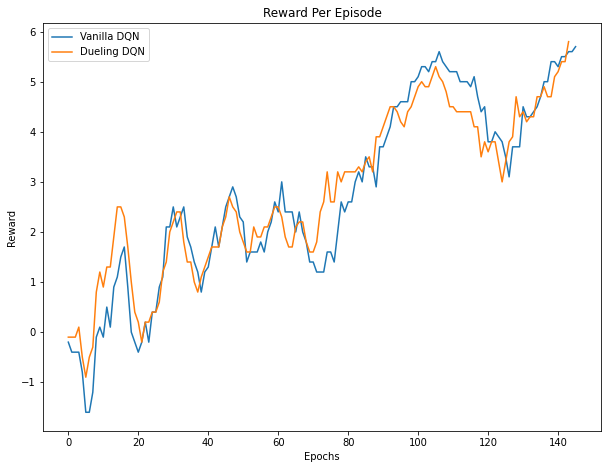

In [35]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(gridWorldRes['running_reward_list'])), gridWorldRes['running_reward_list'], label = 'Vanilla DQN')
plt.plot(range(len(gridDuelResults['running_reward_list'])), gridDuelResults['running_reward_list'], label = 'Dueling DQN')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

Both perform similarly on GRIDWORLD

## Utility function for OpenAI gym environments

In [4]:
def trainAgent(model, env, learning_rate = 1e-4,
               nn_epochs = 4,
               gamma = 0.99,
               epsilon = 1.0,
               epochs = 1000,
               mem_size = 5000,                                                          
               batch_size = 256,                                                                                                                             
               min_epsilon = 0.001,
               C = 10,
               max_timesteps = 10000,
               update_after_actions = 1,
               running_reward_threshold = 470,
               image_env = False,
               channels_first = False,
               seed = 0,
               loss_fn_name = None,
               reward_fn = None): 
  
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  env.seed(seed)

  rate_of_decay = (min_epsilon/epsilon)**(1/epochs)
  
  #Observation list initialization

  losses = list()
  epsilon_list = list()
  epsilon_list.append(epsilon)
  tot_reward_list = list()
  running_reward_list = list()

  #replay list
  replay = list()

  debug = True

  #setting the loss function
  if(loss_fn_name=='Huber'):
    loss_fn = torch.nn.HuberLoss()
  else:
    loss_fn = torch.nn.MSELoss()

  #Training Loop

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  t = trange(epochs)

  for i in t:
      
    state = env.reset()

    if(image_env==True):
      if(channels_first==False):
        h,w,ch = state.shape
        state = state.reshape((ch,h,w))

  #   state.shape

    completed = False

    loss_ep = list()

    tot_reward = 0

    steps = 1

    model_ = copy.deepcopy(model)

    while not completed:

      current_state = copy.deepcopy(state)
      if(image_env and channels_first==False):
        current_state = current_state.reshape((ch,h,w))
      current_state_oh = torch.from_numpy(current_state.astype(np.double)).float()
      if torch.cuda.is_available():
          current_state_oh = current_state_oh.cuda()
      if(image_env==True):
        qval = model(current_state_oh[None, ...])                                                   
      else: 
        qval = model(current_state_oh)                                                   
      qval_ = qval.data.cpu().numpy()

      if (random.random() < epsilon):                                       
        current_action = np.random.choice(env.action_space.n)
      else:
        current_action = np.argmax(qval_)

      # print(current_action)

      state, reward, done, info = env.step(current_action)

      future_state = copy.deepcopy(state)

      if(image_env==True and channels_first==False):
        future_state = future_state.reshape((ch, h, w))

      if(reward_fn=='mech'):
        reward = 100*((math.sin(3*future_state[0]) * 0.0025 + 0.5 * future_state[1] * future_state[1]) - (math.sin(3*current_state[0]) * 0.0025 + 0.5 * current_state[1] * current_state[1]))

      tot_reward+=reward
      
      record = list([current_state, current_action, reward, future_state, done])

      # print(record)
      
      if len(replay) < mem_size: 
        replay.append(record)
      if len(replay) >= mem_size:
        replay = replay[1:]
    

      if len(replay) >= batch_size and steps%update_after_actions==0:
        minibatch = random.sample(replay, batch_size)
        
        action_ = list()
        reward_ = list()
        done_ = list()
        state1_ = list()
        state2_ = list()

        for val in minibatch:

          state1_.append(val[0])

          action_.append(val[1])
          
          reward_.append(val[2])
          
          state2_.append(val[3])
          
          done_.append(val[4])
          
        
        action_ = np.array(action_)
        reward_ = np.array(reward_)
        done_ = np.array(done_, dtype = np.int8)
        state1_ = np.array(state1_)
        state2_ = np.array(state2_)

        state1_batch = torch.from_numpy(state1_).cuda()
        action_batch = torch.from_numpy(action_).cuda()
        reward_batch = torch.from_numpy(reward_).cuda()
        state2_batch = torch.from_numpy(state2_).cuda()
        done_batch = torch.from_numpy(done_).cuda()
        
        for _ in range(nn_epochs):
          Q1 = model(state1_batch.float())                                           
          with torch.no_grad():
              Q2 = model_(state2_batch.float())                                      
          
          Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])
          Y = Y.to(torch.float32)
          X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
          loss = loss_fn(X, Y.detach()).float()
          optimizer.zero_grad()
          loss.backward()
          loss_ep.append(loss.item())
          optimizer.step()
          # scheduler.step(loss)
      steps+=1
      if(steps%C==0):
          model_ = copy.deepcopy(model) 

      completed = True if (done or steps>=max_timesteps) else False
    epsilon = epsilon*rate_of_decay
    epsilon_list.append(epsilon)
    tot_reward_list.append(tot_reward)
    if(len(loss_ep)==0):
      losses.append(float('inf'))
    else:
      losses.append(np.average(loss_ep))
    if(len(tot_reward_list)>=10):
      running_reward = np.mean(tot_reward_list[-10:])
      running_reward_list.append(running_reward)
    else:
      running_reward = tot_reward
    t.set_postfix(loss=np.average(loss_ep), reward = tot_reward, running_reward = running_reward)
    if(running_reward_threshold!=None):
      if(running_reward>=running_reward_threshold):
        print(f"Solved environment at {i+1} epoch. Average running reward: {running_reward:.2f}")
        break

  losses = np.array(losses)

  env.close()

  return {
      'model': model,
      'loss_per_episode' : losses,
      'reward_per_episode' : tot_reward_list,
      'running_reward_list': running_reward_list,
      'epsilon_per_episode': epsilon_list
  }


## II. CartPole-v1

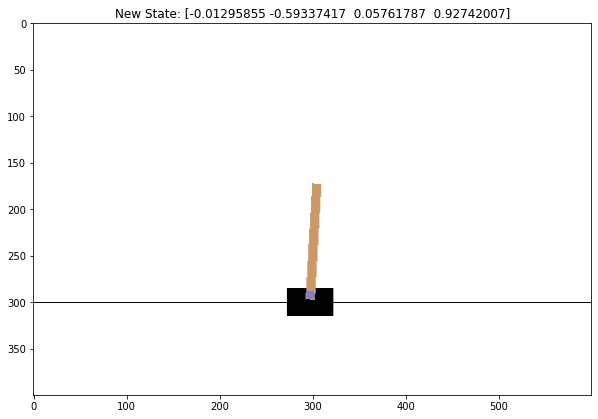

In [37]:
cartpole_env = gym.make('CartPole-v1')

# Let's watch how an untrained agent moves around
state = cartpole_env.reset()
prev_screen = cartpole_env.render(mode='rgb_array')
plt.imshow(prev_screen)
for j in range(10):
    action = random.choice(range(2))
    screen = cartpole_env.render(mode='rgb_array')
    plt.title(f"New State: {state}")
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = cartpole_env.step(action)
    if done:
        break

ipythondisplay.clear_output(wait=True)        
cartpole_env.close()

### a) Vanilla DQN

In [38]:
# l1 = 4 as state space dimensions
l1 = 4
l2 = 32
l3 = 2
# l3 = 2 becausse of size of action_space
cartpole_vanilla_dqn = torch.nn.Sequential(
  torch.nn.Linear(l1, l2),
  torch.nn.ReLU(),
  torch.nn.Linear(l2, l3),
)
if torch.cuda.is_available():
  cartpole_vanilla_dqn = cartpole_vanilla_dqn.cuda()

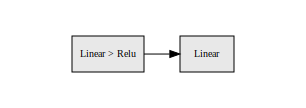

In [39]:
hl.build_graph(cartpole_vanilla_dqn, torch.zeros([1, 4]).cuda())

In [40]:
vanillaCartpoleRes = trainAgent(cartpole_vanilla_dqn, cartpole_env, epochs=5000, nn_epochs=1, C = 1)

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Solved environment at 3151 epoch. Average running reward: 488.30


In [46]:
torch.save(cartpole_vanilla_dqn.state_dict(), 'cartpoleVDQN.pth')

# download checkpoint file
files.download('cartpoleVDQN.pth')

state_dict = torch.load('cartpoleVDQN.pth')
# print(state_dict.keys())
cartpole_vanilla_dqn.load_state_dict(state_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<All keys matched successfully>

In [47]:
losses = vanillaCartpoleRes['loss_per_episode']
tot_reward_list = vanillaCartpoleRes['reward_per_episode']
epsilon_list = vanillaCartpoleRes['epsilon_per_episode']
running_reward_list = vanillaCartpoleRes['running_reward_list']

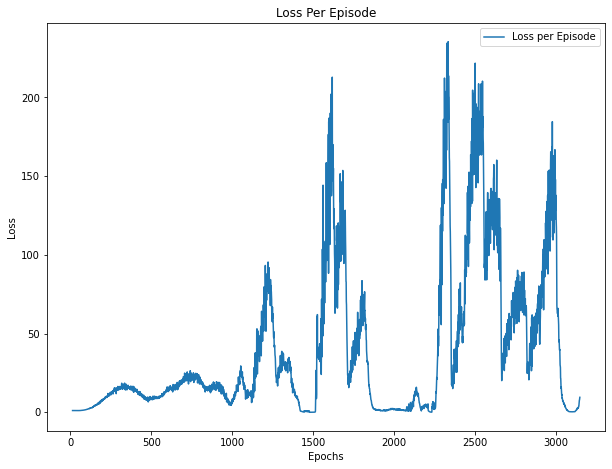

In [48]:
plt.title("Loss Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, label = 'Loss per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

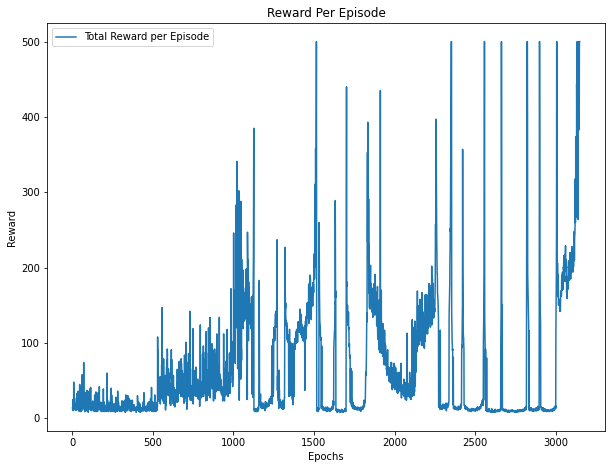

In [49]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(tot_reward_list)), tot_reward_list, label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

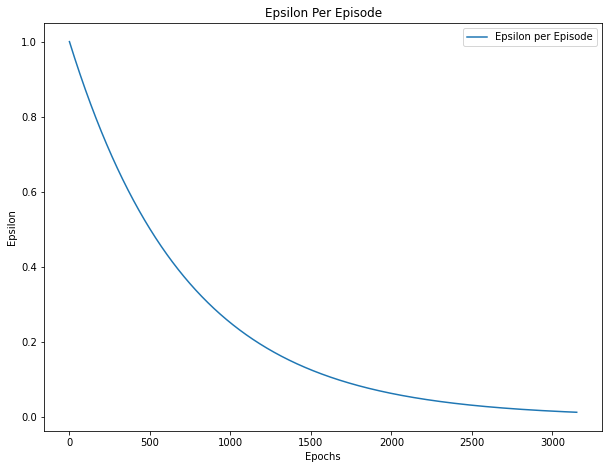

In [50]:
plt.title("Epsilon Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.plot(range(len(epsilon_list)), epsilon_list, label = 'Epsilon per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

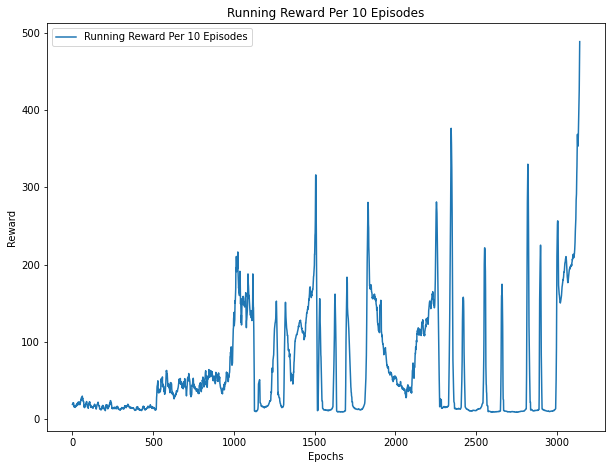

In [51]:
plt.title("Running Reward Per 10 Episodes")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(running_reward_list)), running_reward_list, label = 'Running Reward Per 10 Episodes')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

In [16]:
def evaluateAgent(agent, env, reward_fn = None):
  r_list = list()

  for i in range(100):
    state = env.reset()
  #   prev_screen = cartpole_env.render(mode='rgb_array')
  #   plt.imshow(prev_screen)

    completed = False

    loss_ep = list()

    tot_reward = 0

    reward_per_step = list()

    while not completed:

      current_state = copy.deepcopy(state)
      current_state_oh = torch.from_numpy(current_state.astype(np.double)).float()
      if torch.cuda.is_available():
          current_state_oh = current_state_oh.cuda()
      qval = agent(current_state_oh)                                                   
      qval_ = qval.data.cpu().numpy()

      current_action = np.argmax(qval_)
      
      state, reward, done, info = env.step(current_action)

      if(reward_fn=='mech'):
        reward = 100*((math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]) - (math.sin(3*current_state[0]) * 0.0025 + 0.5 * current_state[1] * current_state[1]))

      tot_reward += reward

      reward_per_step.append(tot_reward)

      # screen = cartpole_env.render(mode='rgb_array')
      # plt.imshow(screen)
      # ipythondisplay.display(plt.gcf())
      # ipythondisplay.clear_output(wait=True)
      # state, reward, done, _ = cartpole_env.step(action)
      # print(f"Episode: {i+1}, New State: {state}")
      if done:
          break
      completed = True if done else False 
    r_list.append(reward_per_step)

  # ipythondisplay.clear_output(wait=True)
  env.close()
  avg_reward = np.mean(np.array([x[-1] for x in r_list]))


  return r_list, avg_reward

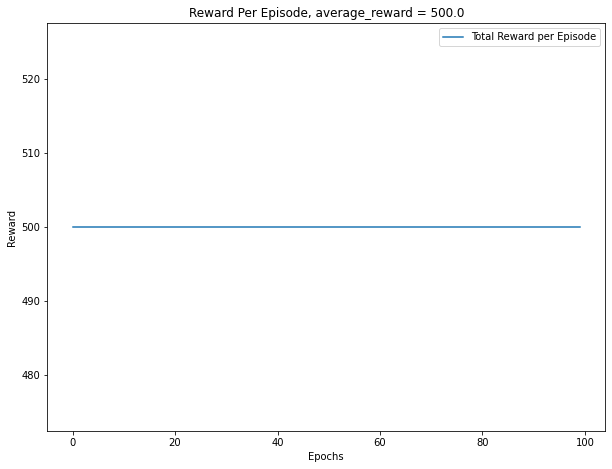

In [53]:
r_list, avg_reward = evaluateAgent(cartpole_vanilla_dqn, cartpole_env)

plt.title(f"Reward Per Episode, average_reward = {avg_reward}")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len([x[-1] for x in r_list])), [x[-1] for x in r_list], label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

### b) Dueling DQN

In [20]:
class DuelDQN(torch.nn.Module):
  def __init__(self, input_dims, output_dims):
    super(DuelDQN, self).__init__()
    self.input_dims = input_dims
    self.output_dims = output_dims

    self.features_network = torch.nn.Sequential(
      torch.nn.Linear(self.input_dims, 32),
      torch.nn.ReLU(),
      torch.nn.Linear(32, 32),
      torch.nn.ReLU()
    )
    self.value_network = torch.nn.Sequential(
      torch.nn.Linear(32, 32),
      torch.nn.ReLU(),
      torch.nn.Linear(32,1)
    )
    self.advantage_network = torch.nn.Sequential(
      torch.nn.Linear(32, 32),
      torch.nn.ReLU(),
      torch.nn.Linear(32,self.output_dims)
    )
  
  def forward(self, state):
    features = self.features_network(state)
    value = self.value_network(features)
    adv = self.advantage_network(features)
    q_val = value+(adv - adv.mean())
    return q_val

In [90]:
# input_dims = 4 as it will receive the state vector
# output_dims = 2 becausse of size of action_space
cartpole_model = DuelDQN(4,2)
if torch.cuda.is_available():
  cartpole_model = cartpole_model.cuda()

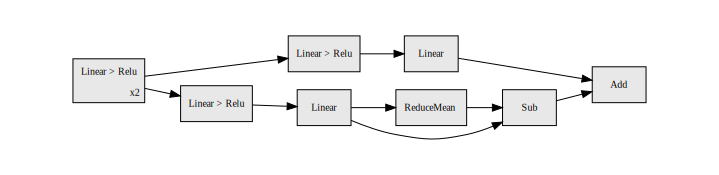

In [91]:
hl.build_graph(cartpole_model, torch.zeros([1, 4]).cuda())

In [92]:
cartpoleRes = trainAgent(cartpole_model, cartpole_env)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Solved environment at 671 epoch. Average running reward: 477.50


In [93]:
torch.save(cartpole_model.state_dict(), 'cartpoleDDQN.pth')

# download checkpoint file
files.download('cartpoleDDQN.pth')

state_dict = torch.load('cartpoleDDQN.pth')
# print(state_dict.keys())
cartpole_model.load_state_dict(state_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<All keys matched successfully>

In [94]:
losses = cartpoleRes['loss_per_episode']
tot_reward_list = cartpoleRes['reward_per_episode']
epsilon_list = cartpoleRes['epsilon_per_episode']
running_reward_list = cartpoleRes['running_reward_list']
# cartpole_model = cartpoleRes['model']

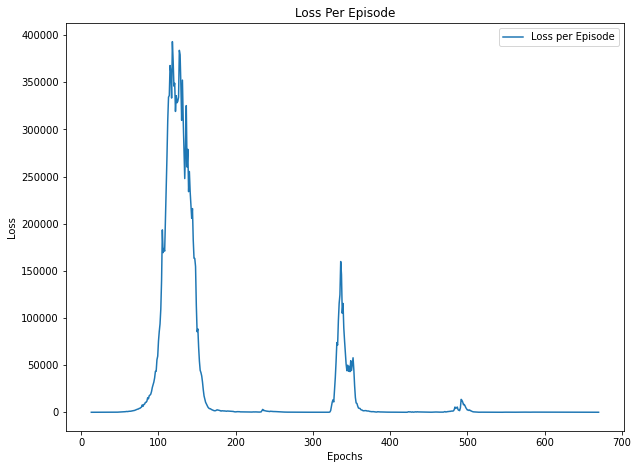

In [95]:
plt.title("Loss Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, label = 'Loss per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

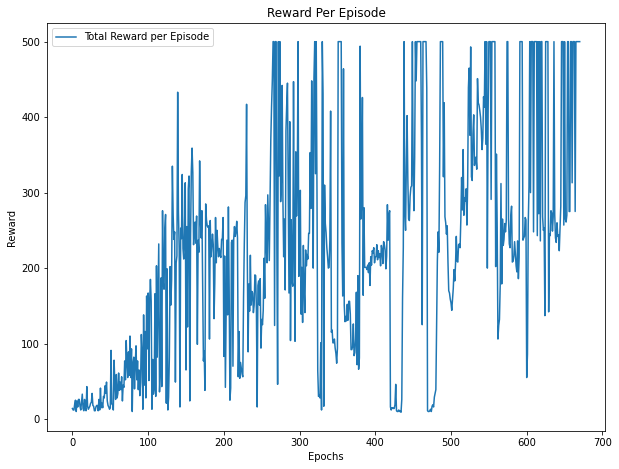

In [96]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(tot_reward_list)), tot_reward_list, label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

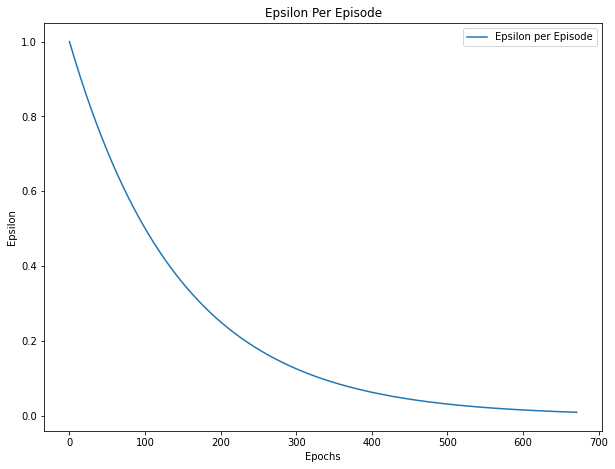

In [97]:
plt.title("Epsilon Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.plot(range(len(epsilon_list)), epsilon_list, label = 'Epsilon per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

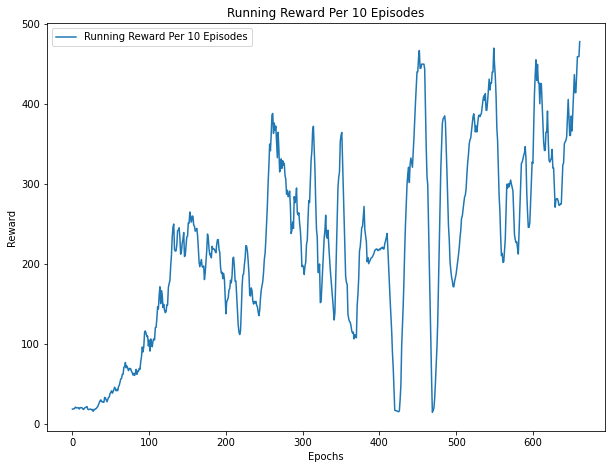

In [98]:
plt.title("Running Reward Per 10 Episodes")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(running_reward_list)), running_reward_list, label = 'Running Reward Per 10 Episodes')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

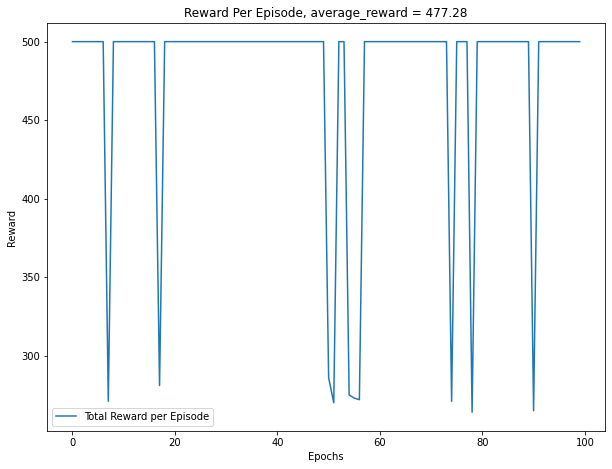

In [99]:
r_list, avg_reward = evaluateAgent(cartpole_model, cartpole_env)

plt.title(f"Reward Per Episode, average_reward = {avg_reward}")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len([x[-1] for x in r_list])), [x[-1] for x in r_list], label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

### c) Comparison

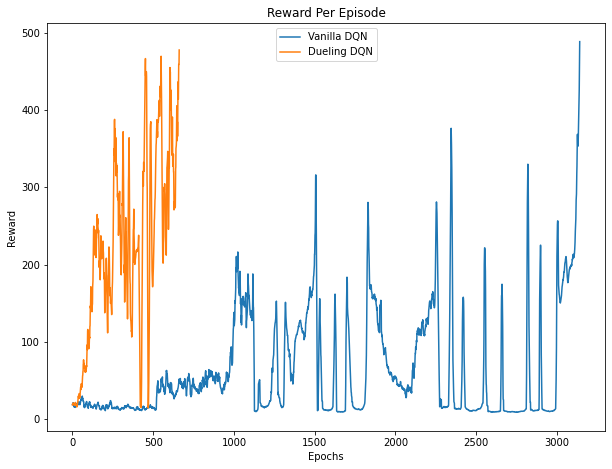

In [100]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(vanillaCartpoleRes['running_reward_list'])), vanillaCartpoleRes['running_reward_list'], label = 'Vanilla DQN')
plt.plot(range(len(cartpoleRes['running_reward_list'])), cartpoleRes['running_reward_list'], label = 'Dueling DQN')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

## III. MountainCar-v0

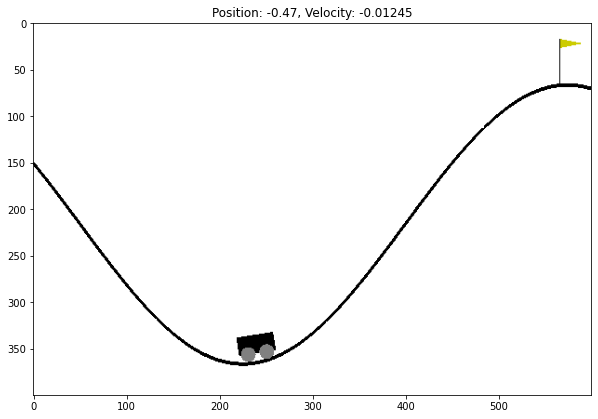

In [5]:
mountain_env = gym.make('MountainCar-v0')
mountain_env.seed(0)
mountain_env.reset()

# Let's watch how an untrained agent moves around

state = mountain_env.reset()
prev_screen = mountain_env.render(mode='rgb_array')
plt.title(f"Position: {state[0]:.2f}, Velocity: {state[1]:.5f}")
plt.imshow(prev_screen)
for j in range(10):
#     action = agent.act(state)
    action = random.choice(range(3))
    screen = mountain_env.render(mode='rgb_array')
    plt.title(f"Position: {state[0]:.2f}, Velocity: {state[1]:.5f}")
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = mountain_env.step(action)
    if done:
        break 
        
mountain_env.close()

### a) Vanilla DQN

In [6]:
# l1 = 2 as it will receive the one hot encoded observation space
l1 = 2
l2 = 32
l3 = 3
# l3 = 3 becausse of size of action_space
mountain_vanilla_dqn = torch.nn.Sequential(
  torch.nn.Linear(l1, l2),
  torch.nn.ReLU(),
  torch.nn.Linear(l2, l3),
)
if torch.cuda.is_available():
  mountain_vanilla_dqn = mountain_vanilla_dqn.cuda()

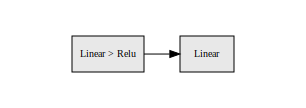

In [7]:
hl.build_graph(mountain_vanilla_dqn, torch.zeros([1, 2]).cuda())

In [8]:
vanillaMountainRes = trainAgent(mountain_vanilla_dqn, mountain_env, epochs=3000, max_timesteps=200, nn_epochs=1, C = 1, reward_fn='mech', running_reward_threshold=0.59)

#observed max reward was 0.62 so threshold 0.59

  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Solved environment at 1050 epoch. Average running reward: 0.59


In [9]:
torch.save(mountain_vanilla_dqn.state_dict(), 'mountainVDQN.pth')

# download checkpoint file
files.download('mountainVDQN.pth')

state_dict = torch.load('mountainVDQN.pth')
# print(state_dict.keys())
mountain_vanilla_dqn.load_state_dict(state_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<All keys matched successfully>

In [10]:
losses = vanillaMountainRes['loss_per_episode']
tot_reward_list = vanillaMountainRes['reward_per_episode']
epsilon_list = vanillaMountainRes['epsilon_per_episode']
running_reward_list = vanillaMountainRes['running_reward_list']
mountain_vanilla_dqn = vanillaMountainRes['model']

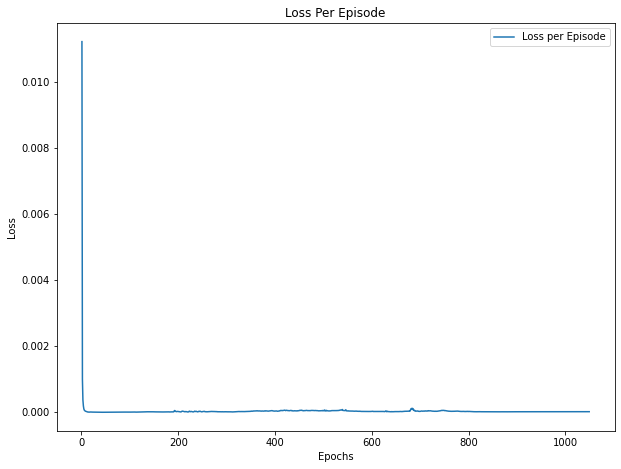

In [11]:
plt.title("Loss Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, label = 'Loss per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

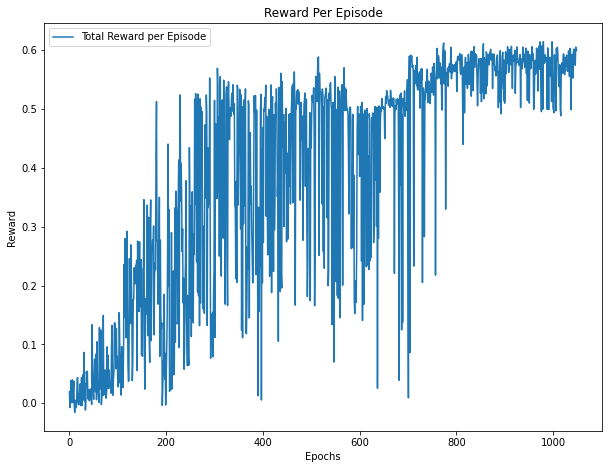

In [12]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(tot_reward_list)), tot_reward_list, label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

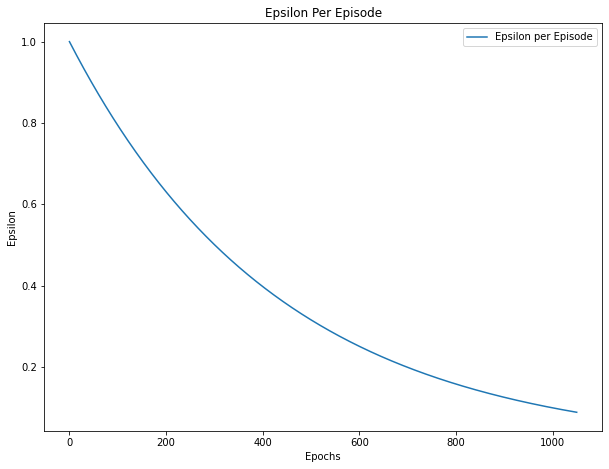

In [13]:
plt.title("Epsilon Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.plot(range(len(epsilon_list)), epsilon_list, label = 'Epsilon per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

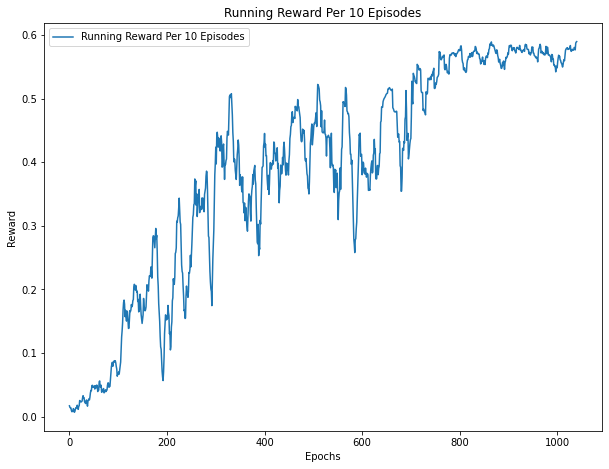

In [14]:
plt.title("Running Reward Per 10 Episodes")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(running_reward_list)), running_reward_list, label = 'Running Reward Per 10 Episodes')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

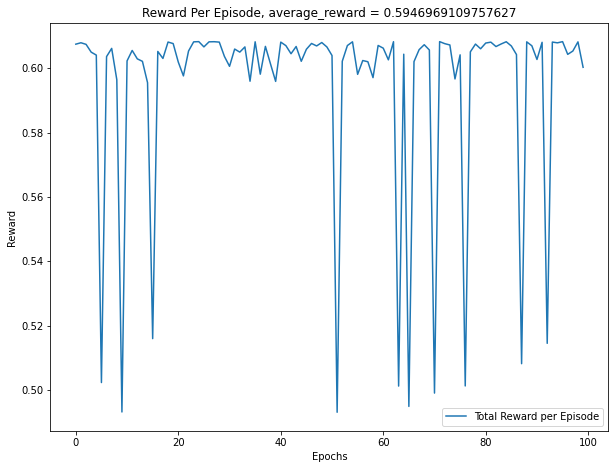

In [17]:
r_list, avg_reward = evaluateAgent(mountain_vanilla_dqn, mountain_env, 'mech')

plt.title(f"Reward Per Episode, average_reward = {avg_reward}")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len([x[-1] for x in r_list])), [x[-1] for x in r_list], label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

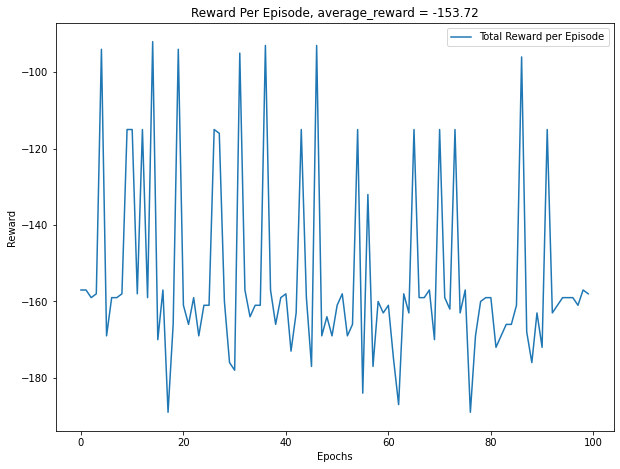

In [18]:
r_list, avg_reward = evaluateAgent(mountain_vanilla_dqn, mountain_env)

plt.title(f"Reward Per Episode, average_reward = {avg_reward}")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len([x[-1] for x in r_list])), [x[-1] for x in r_list], label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

### b) Dueling DQN

In [21]:
# input_dims = 4 as it will receive the state vector
# output_dims = 2 becausse of size of action_space
mountain_ddqn = DuelDQN(2,3)
if torch.cuda.is_available():
  mountain_ddqn = mountain_ddqn.cuda()

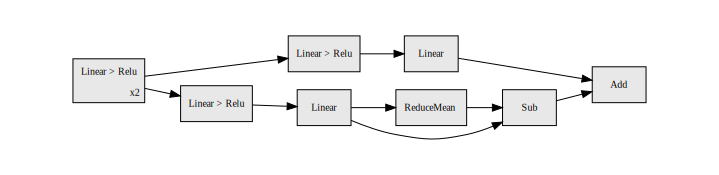

In [22]:
hl.build_graph(mountain_ddqn, torch.zeros([1, 2]).cuda())

In [23]:
mountddqnres = trainAgent(mountain_ddqn, mountain_env, reward_fn = 'mech', max_timesteps=200, running_reward_threshold=0.59)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Solved environment at 295 epoch. Average running reward: 0.59


In [24]:
torch.save(mountain_ddqn.state_dict(), 'mountainDDQN.pth')

# download checkpoint file
files.download('mountainDDQN.pth')

state_dict = torch.load('mountainDDQN.pth')
# print(state_dict.keys())
mountain_ddqn.load_state_dict(state_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<All keys matched successfully>

In [25]:
losses = mountddqnres['loss_per_episode']
tot_reward_list = mountddqnres['reward_per_episode']
epsilon_list = mountddqnres['epsilon_per_episode']
running_reward_list = mountddqnres['running_reward_list']
ddqn_mountain_model = mountddqnres['model']

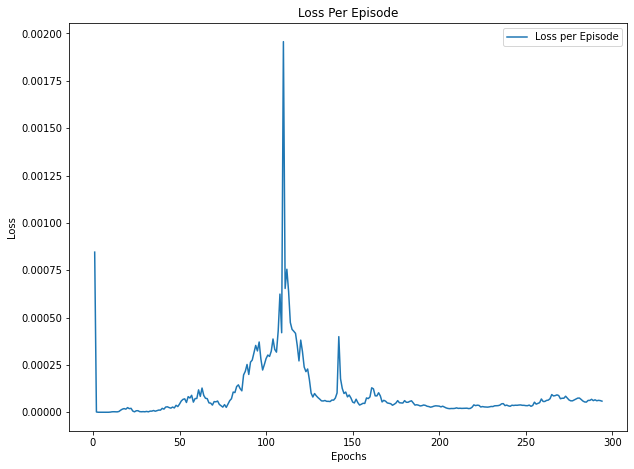

In [26]:
plt.title("Loss Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses)), losses, label = 'Loss per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

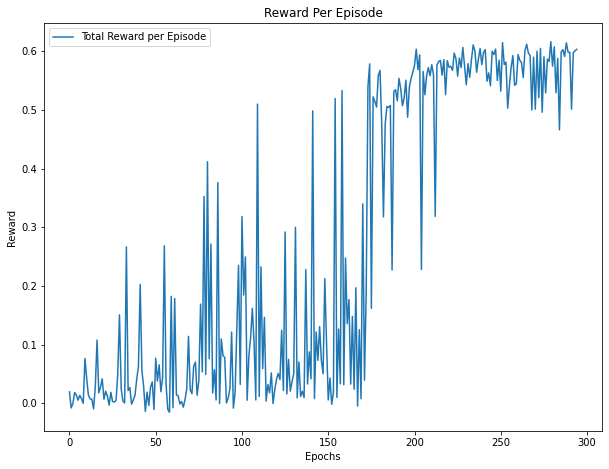

In [27]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(tot_reward_list)), tot_reward_list, label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

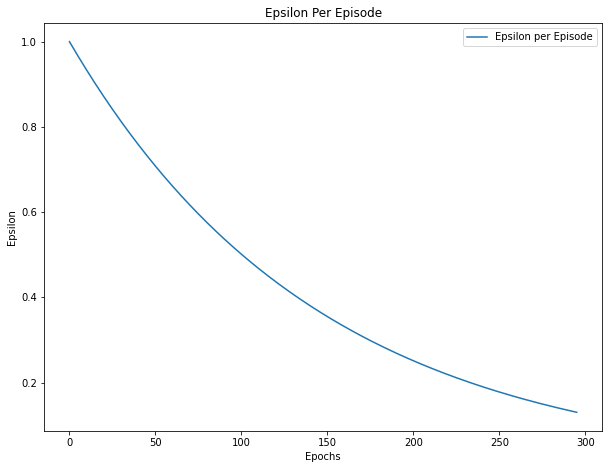

In [28]:
plt.title("Epsilon Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Epsilon")
plt.plot(range(len(epsilon_list)), epsilon_list, label = 'Epsilon per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

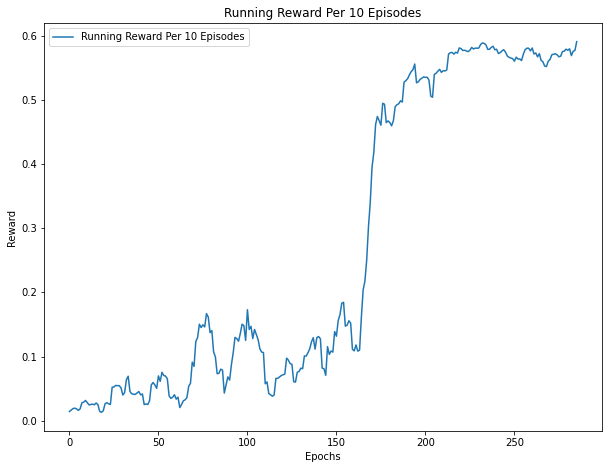

In [29]:
plt.title("Running Reward Per 10 Episodes")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(running_reward_list)), running_reward_list, label = 'Running Reward Per 10 Episodes')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

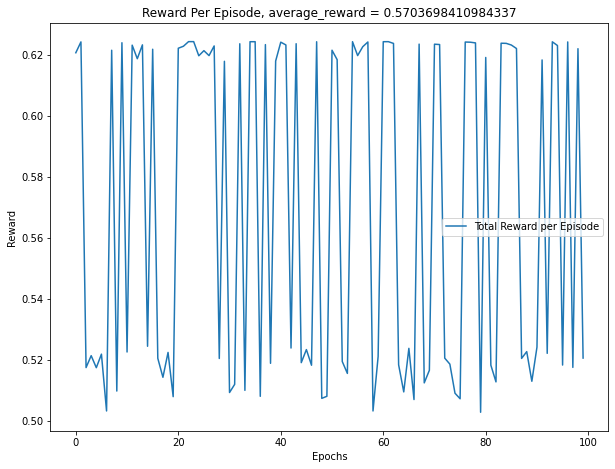

In [30]:
r_list, avg_reward = evaluateAgent(ddqn_mountain_model, mountain_env, 'mech')

plt.title(f"Reward Per Episode, average_reward = {avg_reward}")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len([x[-1] for x in r_list])), [x[-1] for x in r_list], label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

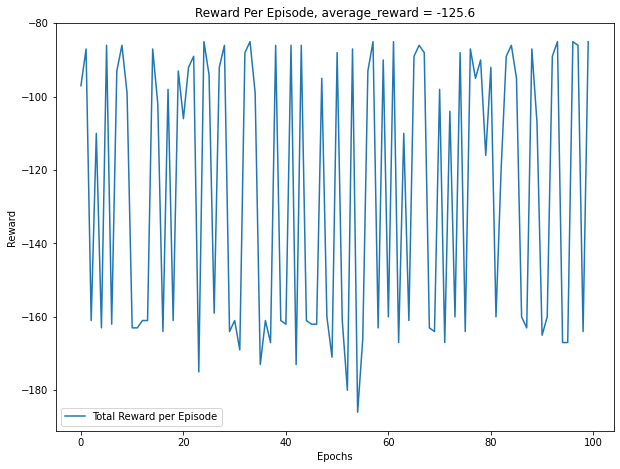

In [31]:
r_list, avg_reward = evaluateAgent(ddqn_mountain_model, mountain_env)

plt.title(f"Reward Per Episode, average_reward = {avg_reward}")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len([x[-1] for x in r_list])), [x[-1] for x in r_list], label = 'Total Reward per Episode')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

### c) Comparison

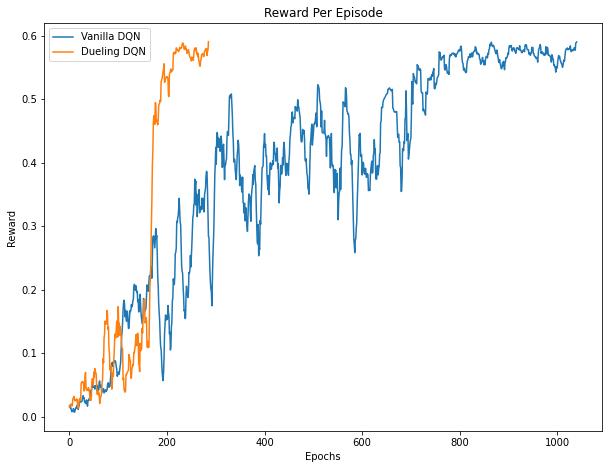

In [32]:
plt.title("Reward Per Episode")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.plot(range(len(vanillaMountainRes['running_reward_list'])), vanillaMountainRes['running_reward_list'], label = 'Vanilla DQN')
plt.plot(range(len(mountddqnres['running_reward_list'])), mountddqnres['running_reward_list'], label = 'Dueling DQN')
# plt.plot(range(10), rewards[:, 5, 1], label = 'Cumulative Reward per episode')
plt.legend()

## IV. Atari Breakout

In [ ]:
# #ROMS credit - http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html
# #code snippet credit - https://github.com/openai/atari-py/issues/83#issuecomment-864356148

! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

In [ ]:
def frame_stack_one_dim(stacked_frames):
  frame = np.zeros((stacked_frames.shape[1:]))
  for i in reversed(range(stacked_frames.shape[0])):
    r = 0.53*((1/2)**i)
    frame+=r*np.array(stacked_frames[i]).astype(np.float32) / 255.0
  return frame

In [ ]:
#Instantiate gym Atari-Breakout environment
breakout_env = gym.make("BreakoutNoFrameskip-v4")
breakout_env = GrayScaleObservation(breakout_env, keep_dim=True)
breakout_env = ResizeObservation(breakout_env, 84)
breakout_env = FrameStack(breakout_env, num_stack = 4, lz4_compress=True)
breakout_env = TransformObservation(breakout_env, lambda x: frame_stack_one_dim(x))
breakout_env = TransformReward(breakout_env, lambda x: np.sign(x))
breakout_env.reset()
n_actions = breakout_env.action_space.n
state_dim = breakout_env.observation_space.shape

In [ ]:
print(f'Action Space: {n_actions}\nObservation Space Dimenions: {state_dim}')

Action Space: 4
Observation Space Dimenions: (4, 84, 84, 1)


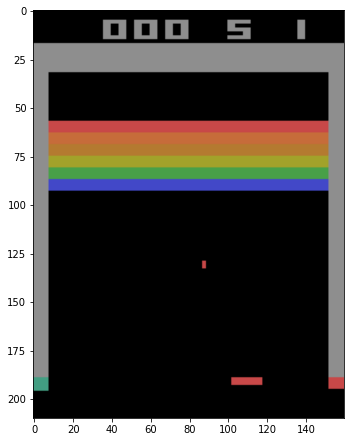

In [ ]:
state = breakout_env.reset()
prev_screen = breakout_env.render(mode='rgb_array')
plt.imshow(prev_screen)
for j in range(10):
    action = random.choice(range(n_actions))
    screen = breakout_env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state, reward, done, _ = breakout_env.step(action)
    if done:
        break 
        
breakout_env.close()

In [ ]:
class ConvDuelDQN(torch.nn.Module):
  def __init__(self, input_dims, output_dims):
    super(ConvDuelDQN, self).__init__()
    self.input_dims = input_dims
    self.output_dims = output_dims
    
    self.features_network = torch.nn.Sequential(
      torch.nn.Conv2d(self.input_dims[2], 32, kernel_size = 8, stride = 4),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
      torch.nn.ReLU()
    )

    self.fc_first_layer_dims = self.features_network(torch.autograd.Variable(torch.zeros(1, *(self.input_dims[2], self.input_dims[0], self.input_dims[1])))).view(1, -1).size(1)

    self.value_network = torch.nn.Sequential(
      torch.nn.Linear(self.fc_first_layer_dims, 512),
      torch.nn.ReLU(),
      torch.nn.Linear(512,1)
    )
    self.advantage_network = torch.nn.Sequential(
      torch.nn.Linear(self.fc_first_layer_dims, 512),
      torch.nn.ReLU(),
      torch.nn.Linear(512,self.output_dims)
    )
  
  def forward(self, state):
    features = self.features_network(state)
    features = features.view(features.size(0), -1)
    value = self.value_network(features)
    adv = self.advantage_network(features)
    q_val = value + (adv - adv.mean())
    return q_val

In [ ]:
convDDQN = ConvDuelDQN(state_dim[1:], n_actions)
if torch.cuda.is_available():
  convDDQN = convDDQN.cuda()

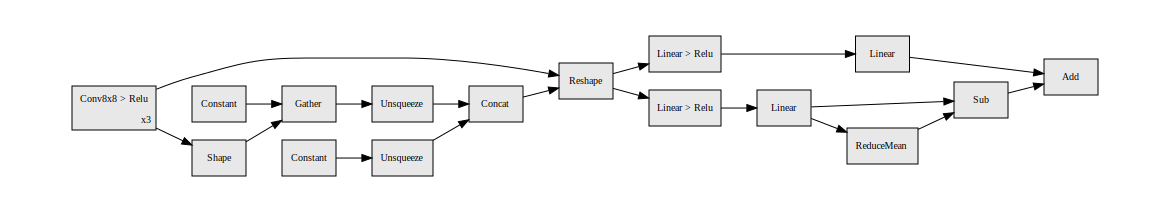

In [ ]:
hl.build_graph(convDDQN, torch.zeros([1, state_dim[3], state_dim[1], state_dim[2]]).cuda())

In [ ]:
summary(convDDQN.cuda(), (state_dim[3], state_dim[1], state_dim[2]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           2,080
              ReLU-2           [-1, 32, 20, 20]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 512]       1,606,144
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 1]             513
           Linear-10                  [-1, 512]       1,606,144
             ReLU-11                  [-1, 512]               0
           Linear-12                    [-1, 4]           2,052
Total params: 3,286,693
Trainable params: 3,286,693
Non-trainable params: 0
---------------------------

In [ ]:
breakOutDDQNRes = trainAgent(convDDQN, breakout_env, update_after_actions=4, epochs=5000, running_reward_threshold=40, max_timesteps=10000, mem_size=100000, batch_size=32, C=10000, loss_fn_name='Huber', image_env=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
breakout_env.close()